In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
import lightning as L
from lightning import Trainer, LightningModule
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor

from helper import StockDataset, normalize, sliding_window, train_test_split, recover_normalize

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
torch.set_float32_matmul_precision('medium')
L.seed_everything(42)

Global seed set to 42


42

In [3]:
df = pd.read_parquet("./data/close.parquet")
df

,date,close,high,low,volume
0,2000-01-04,6110,6110,5660,1483967
1,2000-01-05,5580,6060,5520,1493604
2,2000-01-06,5620,5780,5580,1087810
3,2000-01-07,5540,5670,5360,806195
4,2000-01-10,5770,5770,5580,937615
...,...,...,...,...,...
5834,2023-08-18,66300,66700,65800,11745006
5835,2023-08-21,66600,67100,66300,9720067
5836,2023-08-22,66600,67700,66300,10500242
5837,2023-08-23,67100,67100,66400,9549352


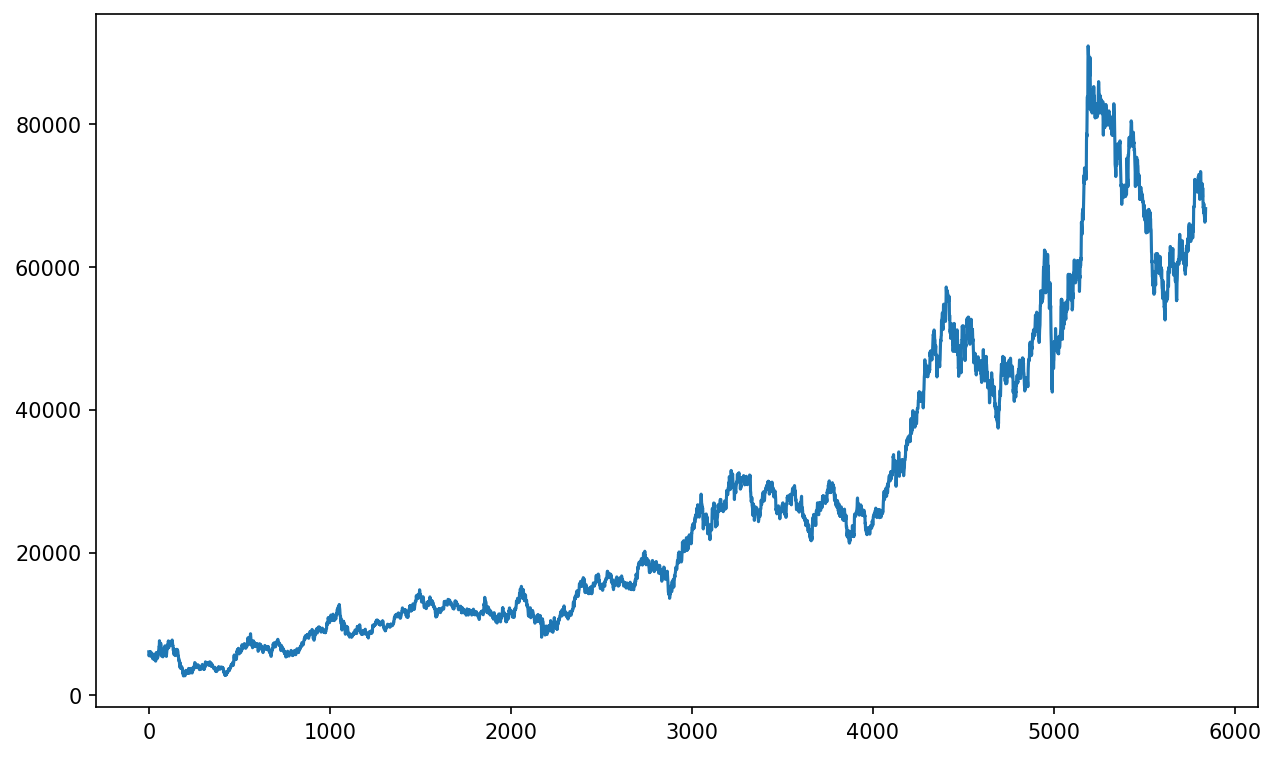

In [4]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(df["close"])
plt.savefig("close.png", bbox_inches="tight", dpi=600)
plt.show()

In [5]:
close = df["close"].to_numpy()
close.shape

(5839,)

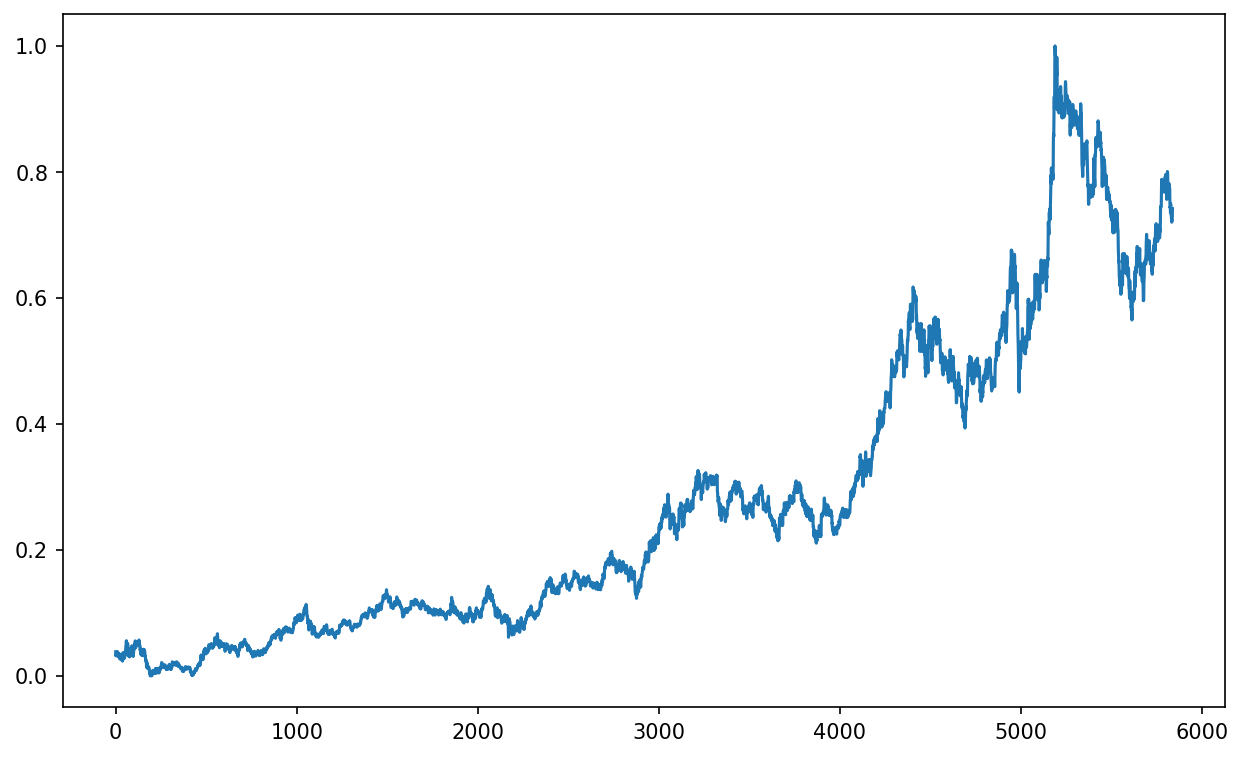

In [6]:
# Normalize
close, close_max, close_min = normalize(close)

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(close)
plt.show()

In [7]:
# bias augmentation
biases = [0.0, 0.25, 0.5, 0.75]
close_aug = np.array([close + bias for bias in biases])
close_aug.shape

(4, 5839)

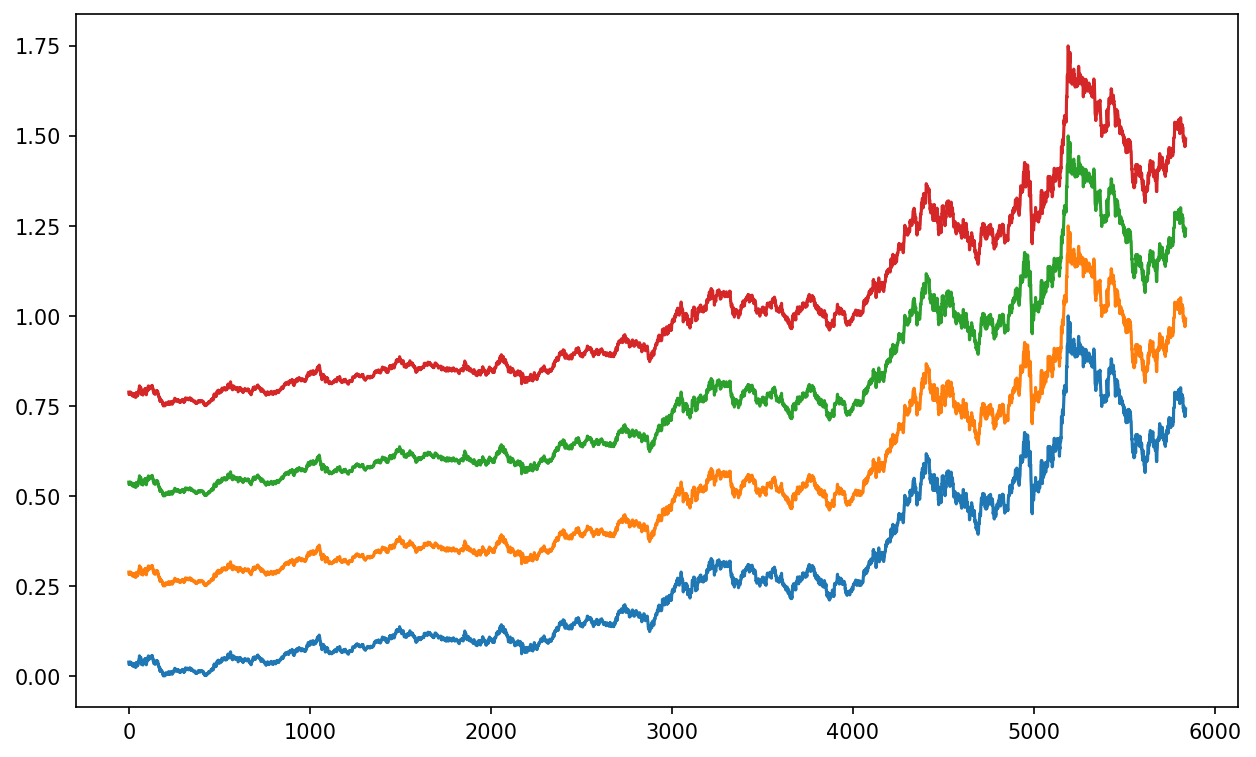

In [8]:
plt.figure(figsize=(10, 6), dpi=150)
for i in range(close_aug.shape[0]):
    plt.plot(close_aug[i])
plt.show()

In [9]:
window_size = 5
horizon_size = 5

In [10]:
#x, y = sliding_window(close, 10, 10)
x_train = []
y_train = []
x_test = []
y_test = []
for bias in biases:
    x, y = sliding_window(close + bias, window_size, horizon_size)
    x = x.reshape((x.shape[0], x.shape[1], 1))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    x_train_, x_test_, y_train_, y_test_ = train_test_split(x, y, 0.8)
    x_train.append(x_train_)
    y_train.append(y_train_)
    x_test.append(x_test_)
    y_test.append(y_test_)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

In [11]:
x_train.shape

(18656, 5, 1)

In [12]:
x_test.shape

(4664, 5, 1)

In [13]:
ds_train = StockDataset(x_train, y_train)
ds_test = StockDataset(x_test, y_test)

In [14]:
dl_train = DataLoader(ds_train, batch_size=256, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=256, shuffle=False)

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1,
            bidirectional=False,
        )

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        return out, (h, c)

class Decoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1,
            bidirectional=False,
        )
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, h_c):
        out, (h, c) = self.lstm(x, h_c)
        out = self.linear(out)
        return out, (h, c)

In [16]:
class LSTM_Seq2Seq(LightningModule):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int,
        lr: float,
    ):
        super().__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.recon_decoder = Decoder(input_size, hidden_size, input_size, num_layers)
        self.pred_decoder = Decoder(input_size, hidden_size, output_size, num_layers)
        self.lr = lr

    def forward(self, x):
        B, W, F_i = x.shape
        _, (h, c) = self.encoder(x)
        h_c0 = (h, c)

        # Recon
        h_c = h_c0
        recon_output = []
        input_t = torch.zeros((B, 1, F_i)).to(self.device)
        for _ in range(W):
            input_t, h_c = self.recon_decoder(input_t, h_c)
            recon_output.append(input_t)
        recon_output = torch.cat(recon_output, dim=1)

        # Pred
        h_c = h_c0
        pred_output = []
        input_t = torch.zeros((B, 1, F_i)).to(self.device)
        for _ in range(horizon_size):
            input_t, h_c = self.pred_decoder(input_t, h_c)
            pred_output.append(input_t)
        pred_output = torch.cat(pred_output, dim=1)
        
        return recon_output, pred_output

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat, y_hat = self(x)

        # Flip input
        x_rev = torch.flip(x, (1,))
        
        loss = F.huber_loss(x_hat, x_rev, delta=0.01) + F.huber_loss(y_hat, y, delta=0.01)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat, y_hat = self(x)

        # Flip input
        x_rev = torch.flip(x, (1,))
        
        loss = F.huber_loss(x_hat, x_rev, delta=0.01) + F.huber_loss(y_hat, y, delta=0.01)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": {
        #         "scheduler": OneCycleLR(
        #             optimizer,
        #             max_lr=self.lr,
        #             epochs=100,
        #             steps_per_epoch=len(dl_train),
        #         ),
        #         "interval": "step",
        #         "monitor": "val_loss",
        #         "strict": True,
        #     }
        # }

In [17]:
model = LSTM_Seq2Seq(1, horizon_size, 1, 4, 1e-3)
model

LSTM_Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 5, num_layers=4, batch_first=True, dropout=0.1)
  )
  (recon_decoder): Decoder(
    (lstm): LSTM(1, 5, num_layers=4, batch_first=True, dropout=0.1)
    (linear): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): GELU(approximate='tanh')
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): GELU(approximate='tanh')
      (4): Linear(in_features=5, out_features=1, bias=True)
    )
  )
  (pred_decoder): Decoder(
    (lstm): LSTM(1, 5, num_layers=4, batch_first=True, dropout=0.1)
    (linear): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): GELU(approximate='tanh')
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): GELU(approximate='tanh')
      (4): Linear(in_features=5, out_features=1, bias=True)
    )
  )
)

In [18]:
x, y = sliding_window(close, window_size, horizon_size)
x = x.reshape((x.shape[0], x.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

In [19]:
# Baseline
x_hat, y_hat = model(torch.from_numpy(x).float())
x_hat = x_hat.detach().numpy()
y_hat = y_hat.detach().numpy()
y_hat.shape

(5830, 5, 1)

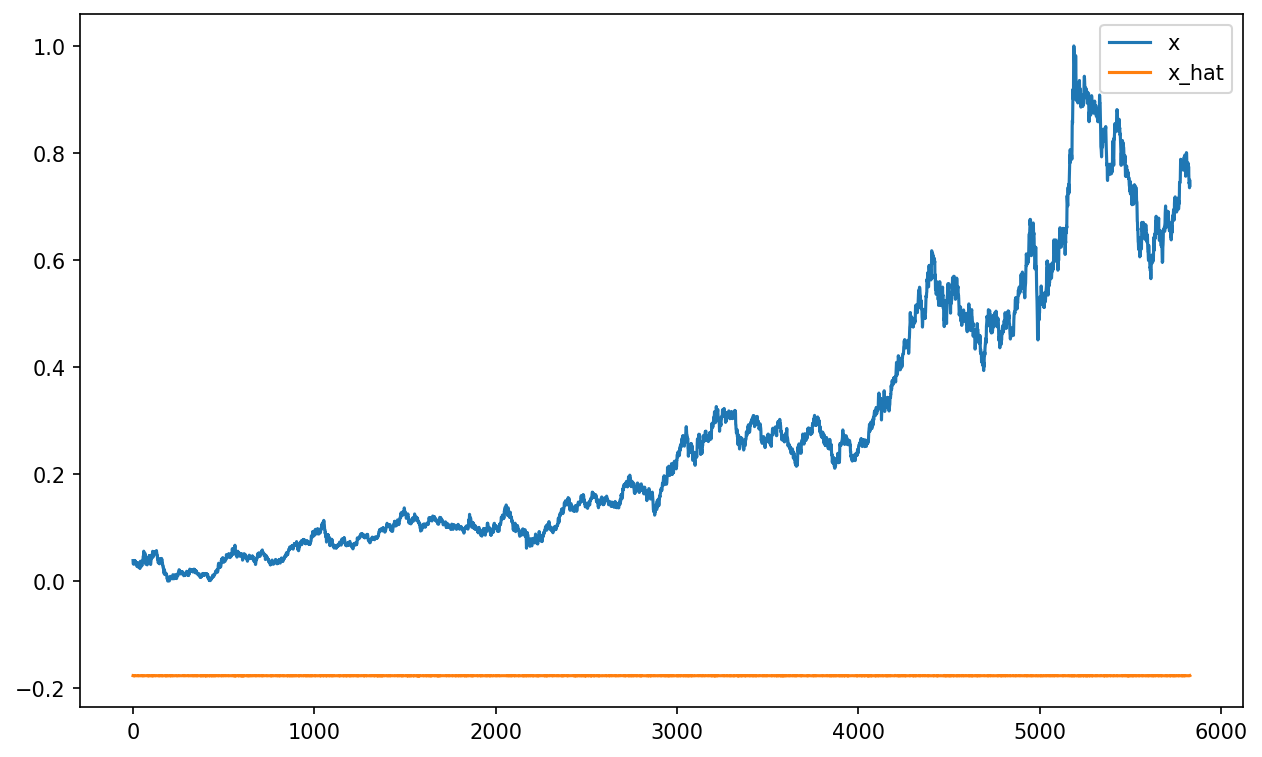

In [20]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x[:, 0], label="x")
plt.plot(x_hat[:, 0], label="x_hat")
plt.legend()
plt.show()

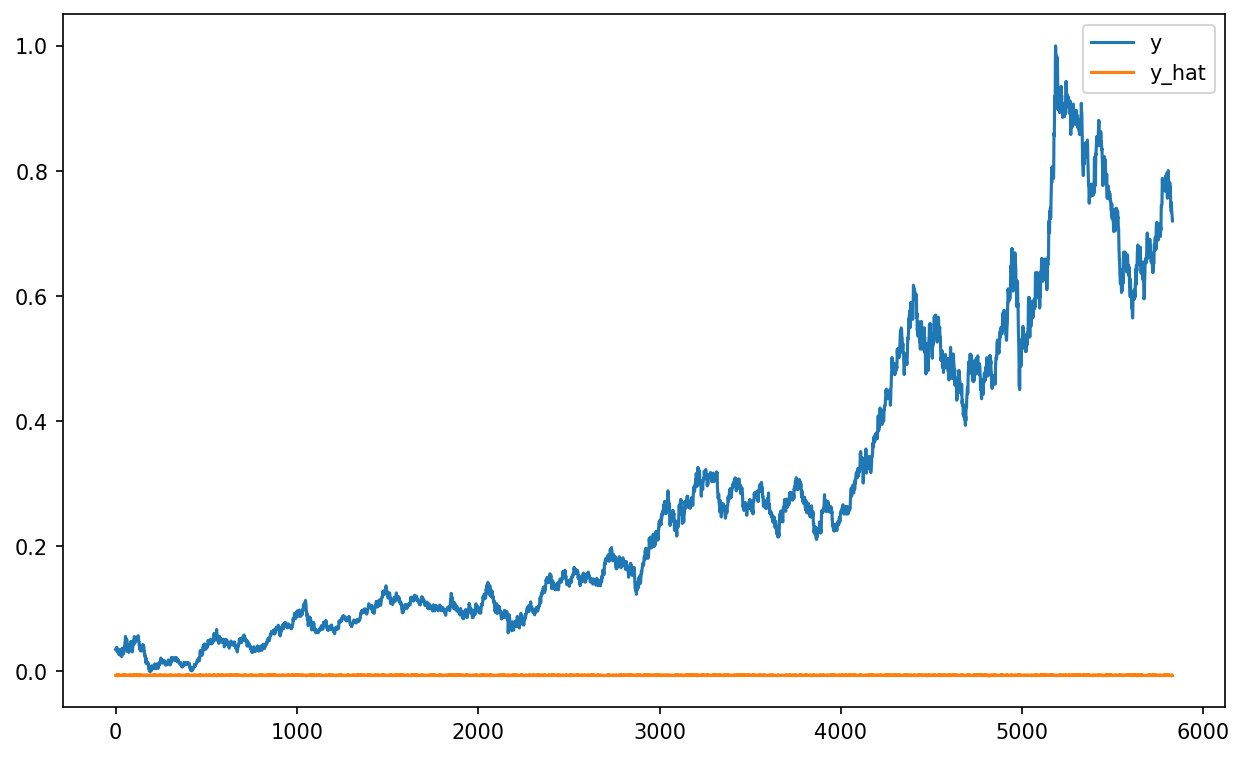

In [21]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y[:, 0], label="y")
plt.plot(y_hat[:, 0], label="y_hat")
plt.legend()
plt.show()

In [22]:
# Wandb logger
wandb_logger = WandbLogger(project="stock_test")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


In [23]:
trainer = Trainer(
    devices=1,
    accelerator='auto',
    max_epochs=500,
    logger=wandb_logger,
    enable_progress_bar=False,
    callbacks=[LearningRateMonitor(logging_interval='step')],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model, dl_train, dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | encoder       | Encoder | 880   
1 | recon_decoder | Decoder | 946   
2 | pred_decoder  | Decoder | 946   
------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/MLTest/new/stock_forecasting/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xteca/Documents/Project/Machine_Learning/MLTest/new/stock_forecasting/.venv/lib/python3.11/site-packages/lightning/pytorch/train

In [25]:
# Test
model.eval()
x_hat, y_hat = model(torch.from_numpy(x).float())
x_hat = x_hat.detach().numpy()
y_hat = y_hat.detach().numpy()
y_hat.shape

(5830, 5, 1)

In [26]:
x = recover_normalize(x, close_max, close_min)
y = recover_normalize(y, close_max, close_min)
x_hat = recover_normalize(x_hat, close_max, close_min)
y_hat = recover_normalize(y_hat, close_max, close_min)

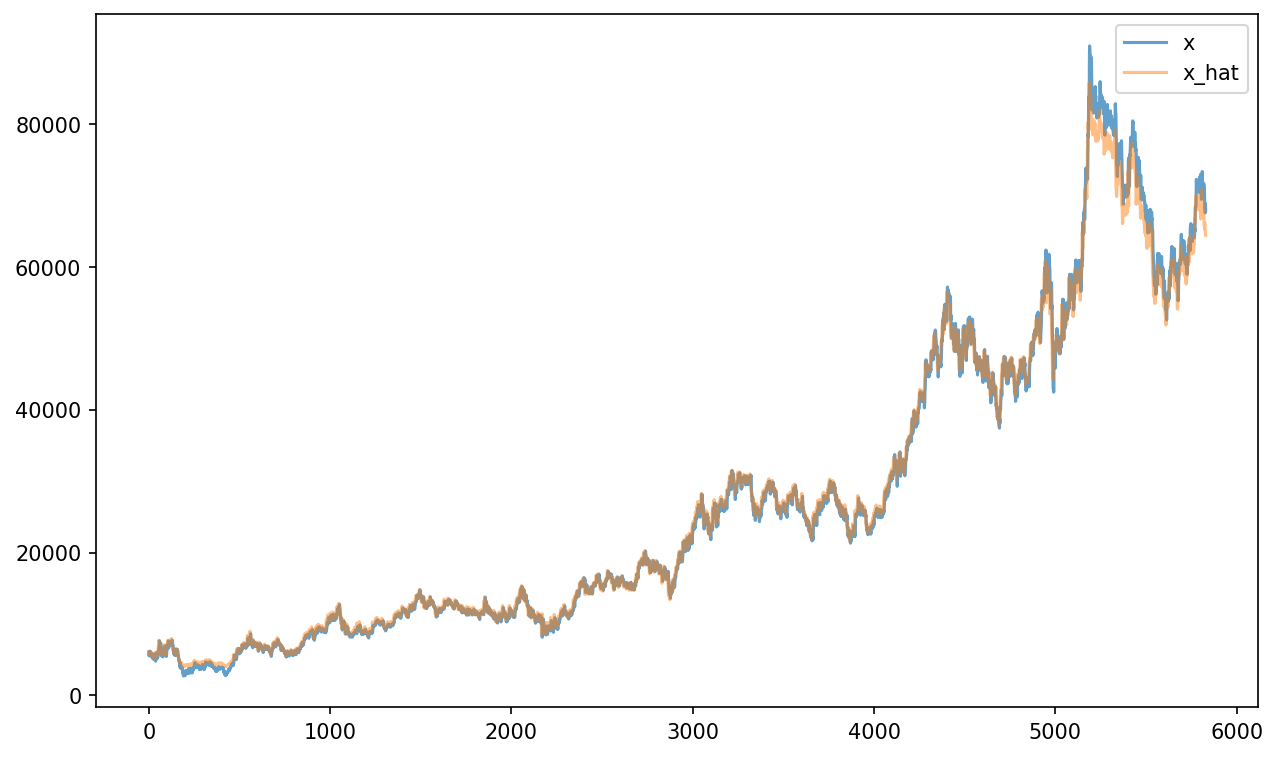

In [27]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x[:,0], label="x", alpha=0.7)
plt.plot(x_hat[:,0], label="x_hat", alpha=0.5)
plt.legend()
plt.savefig("lstm_seq2seq_comp_recon.png", dpi=600)
plt.show()

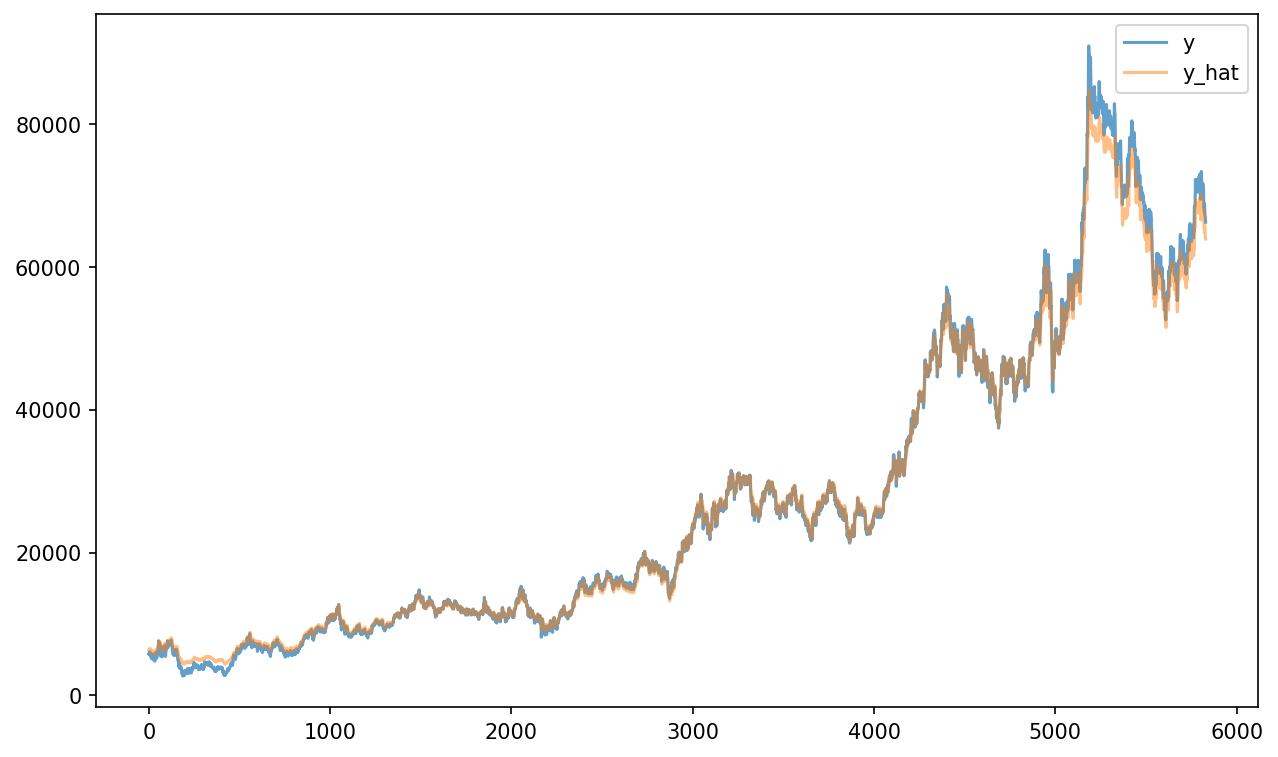

In [28]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y[:,0], label="y", alpha=0.7)
plt.plot(y_hat[:,0], label="y_hat", alpha=0.5)
plt.legend()
plt.savefig("lstm_seq2seq_comp_pred.png", dpi=600)
plt.show()

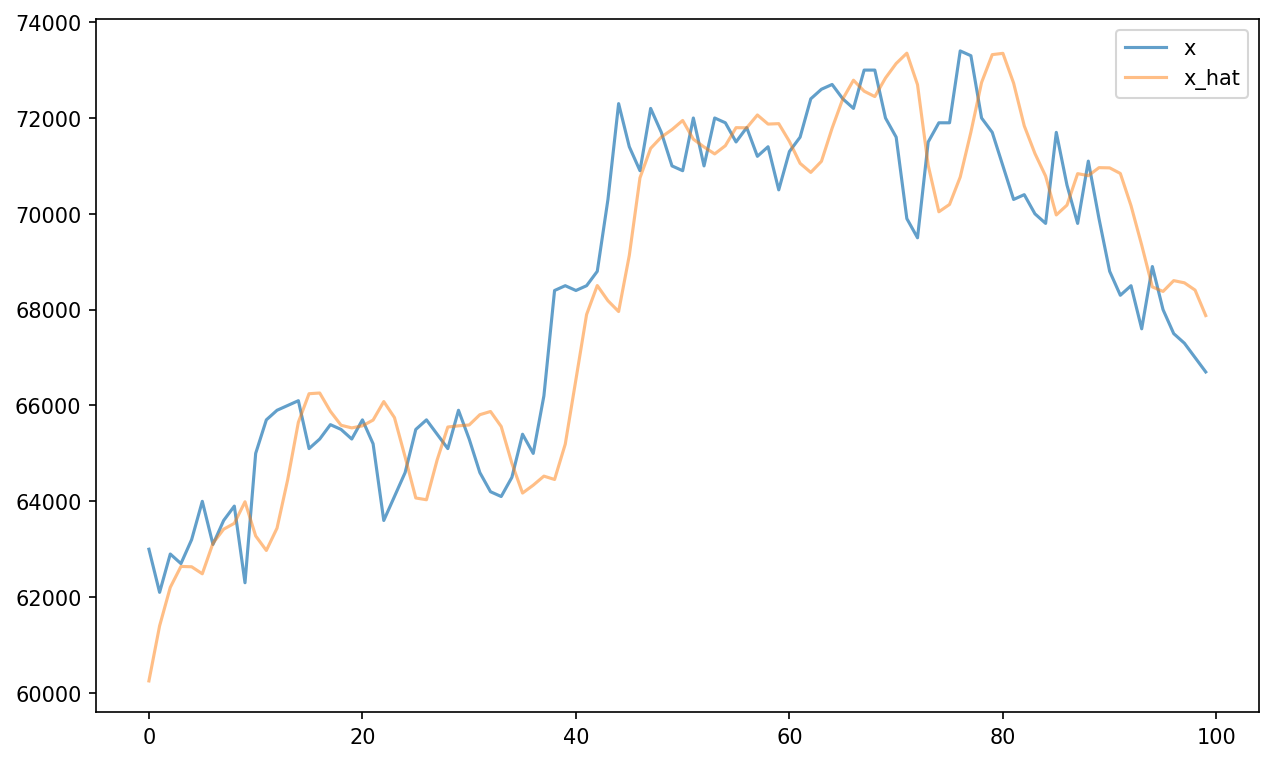

In [29]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x[-100:,-1], label="x", alpha=0.7)
plt.plot(x_hat[-100:,-1], label="x_hat", alpha=0.5)
plt.legend()
plt.savefig("lstm_seq2seq_comp_recon_zoom.png", dpi=600)
plt.show()

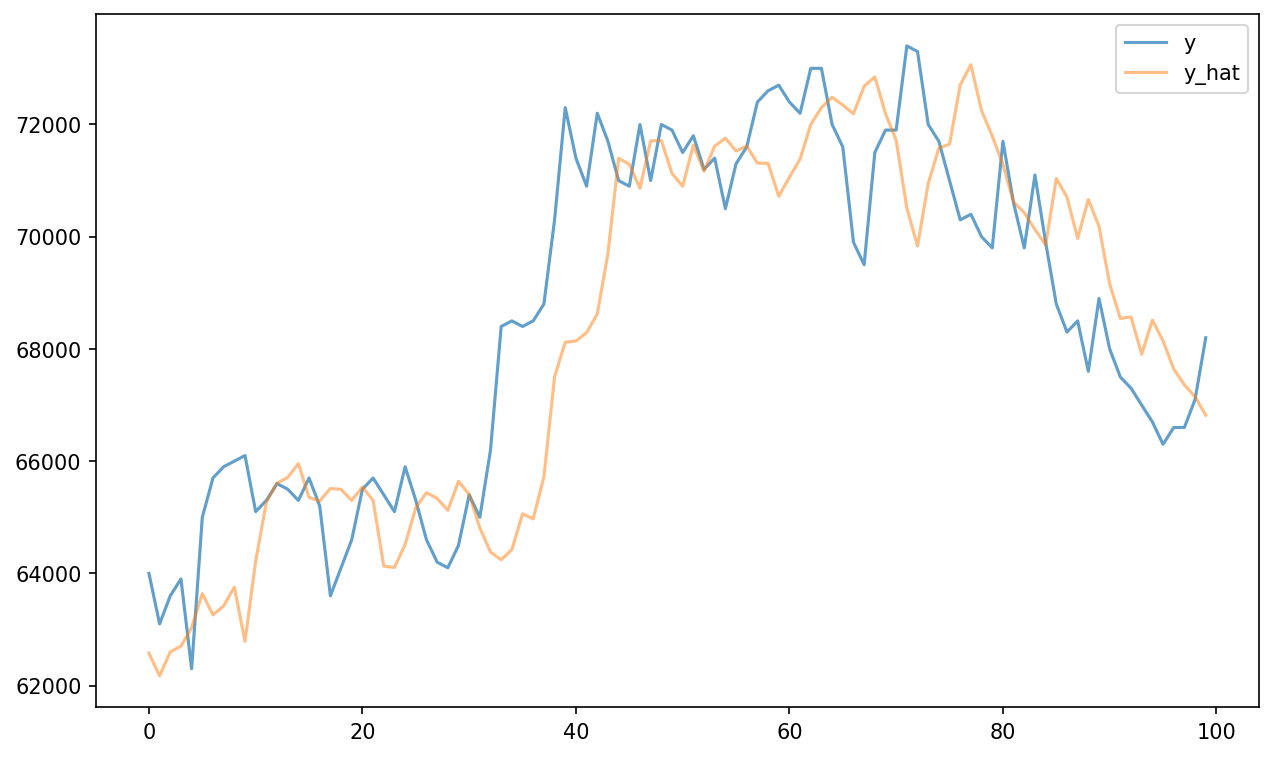

In [30]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y[-100:,-1], label="y", alpha=0.7)
plt.plot(y_hat[-100:,-1], label="y_hat", alpha=0.5)
plt.legend()
plt.savefig("lstm_seq2seq_comp_pred_zoom.png", dpi=600)
plt.show()

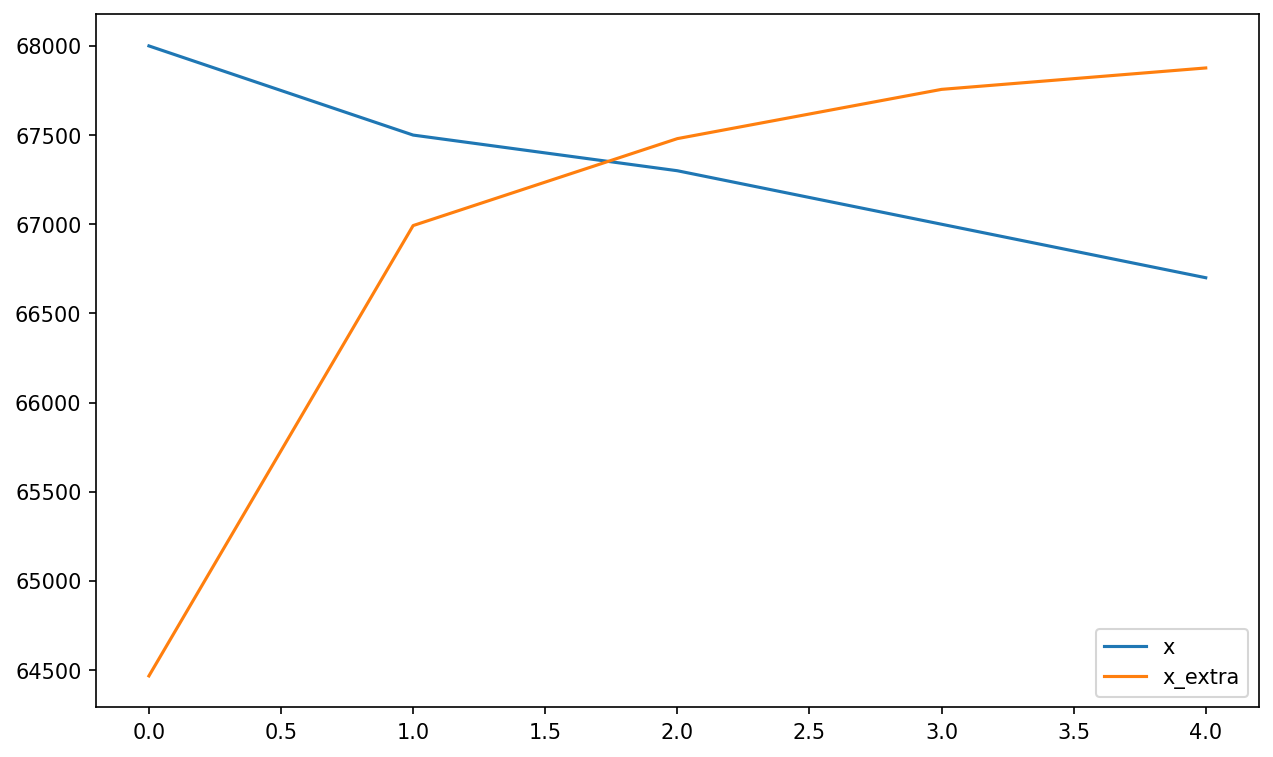

In [31]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x[-1:,:].flatten(), label='x')
plt.plot(x_hat[-1:,:].flatten(), label='x_extra')
plt.legend()
plt.savefig('lstm_seq2seq_comp_recon_extra.png', dpi=600)
plt.show()

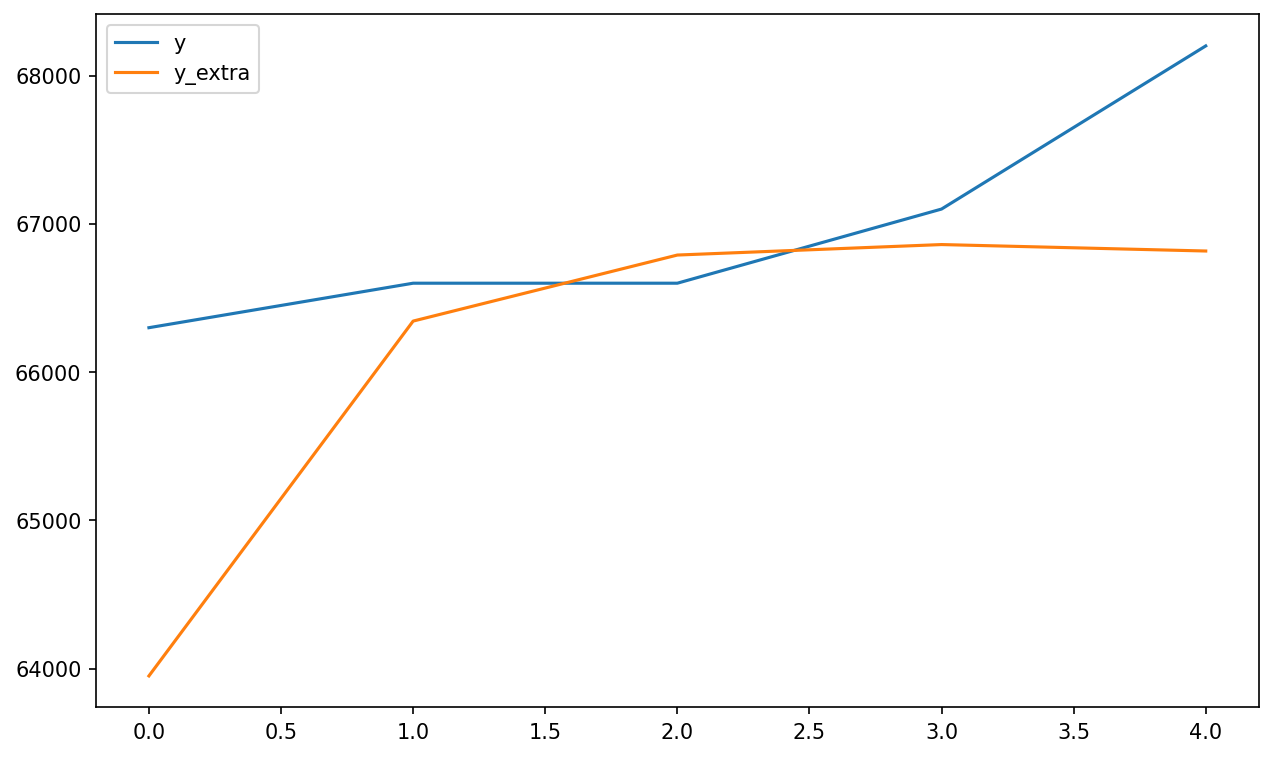

In [32]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y[-1:,:].flatten(), label='y')
plt.plot(y_hat[-1:,:].flatten(), label='y_extra')
plt.legend()
plt.savefig('lstm_seq2seq_comp_pred_extra.png', dpi=600)
plt.show()